## Import packages

In [736]:
import numpy as np
from skimage.io import imread, imshow

## Import image

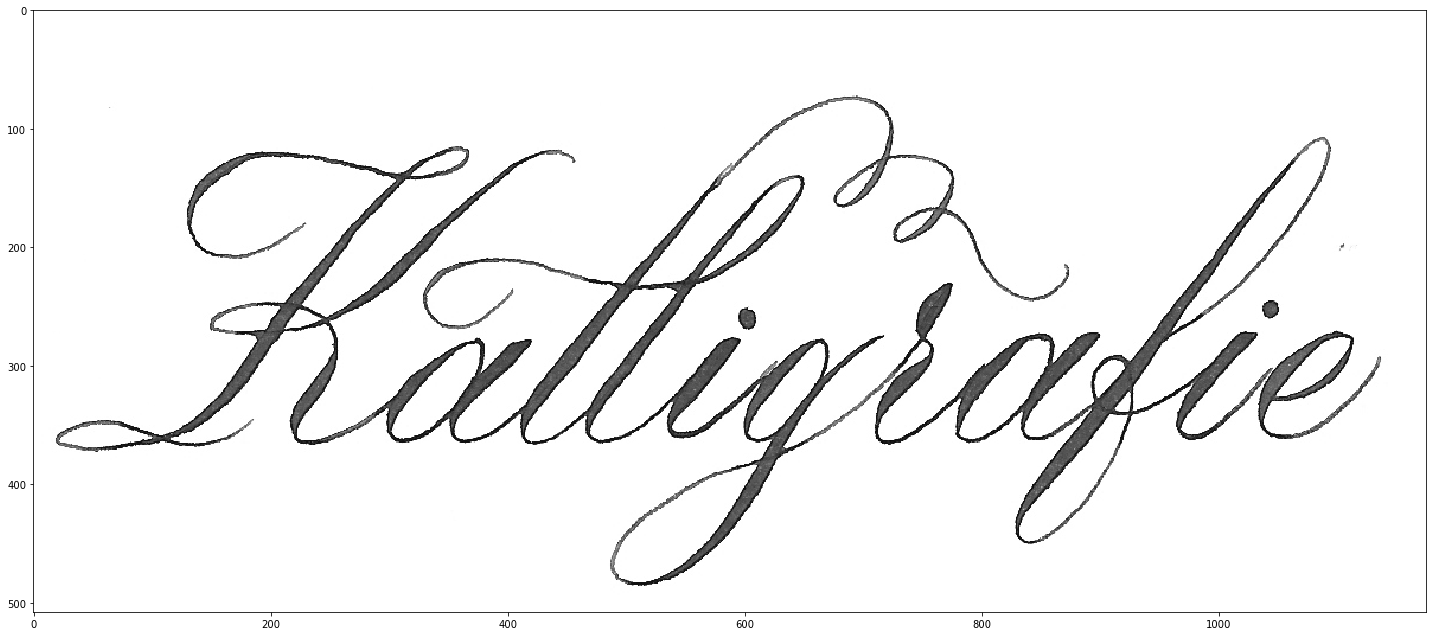

In [737]:
scan = imread('test-files/kalligrafie.png', as_gray=True)
imshow(scan)

## Convert image to binary

In [738]:
import matplotlib.pyplot as plt
import numpy as np
#plt.hist(scan)
#plt.show()

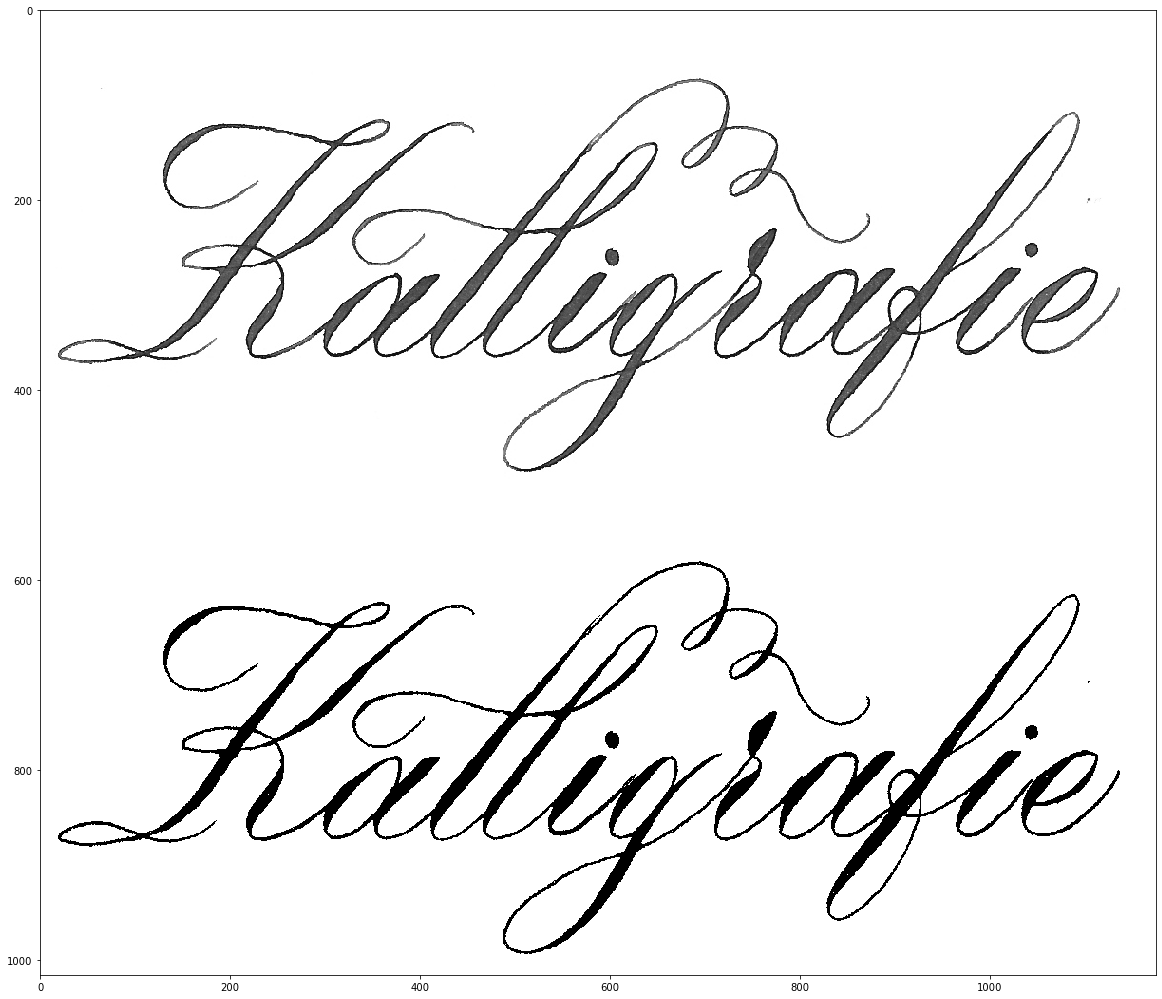

In [739]:
from skimage.filters import threshold_otsu

#threshold = 0.7
threshold = threshold_otsu(scan)

binary = scan > threshold
both = np.vstack((scan, binary))
plt.figure(figsize=(20, 20))
plt.imshow(both, cmap='gray', interpolation='nearest')

## Remove islands

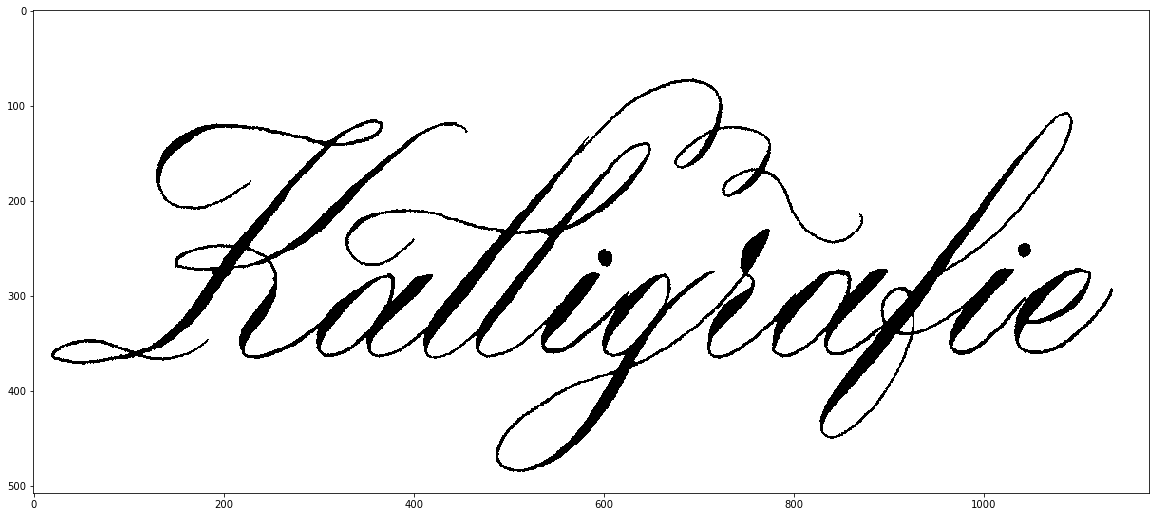

In [886]:
import skimage.morphology as mrp

footprint = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1]
])
footprint = np.array([
    [1, 1],
    [1, 1]
])

x = mrp.remove_small_holes(binary)
x = mrp.remove_small_objects(x)

plt.imshow(x, cmap='gray', interpolation='nearest')

## Contour tracing

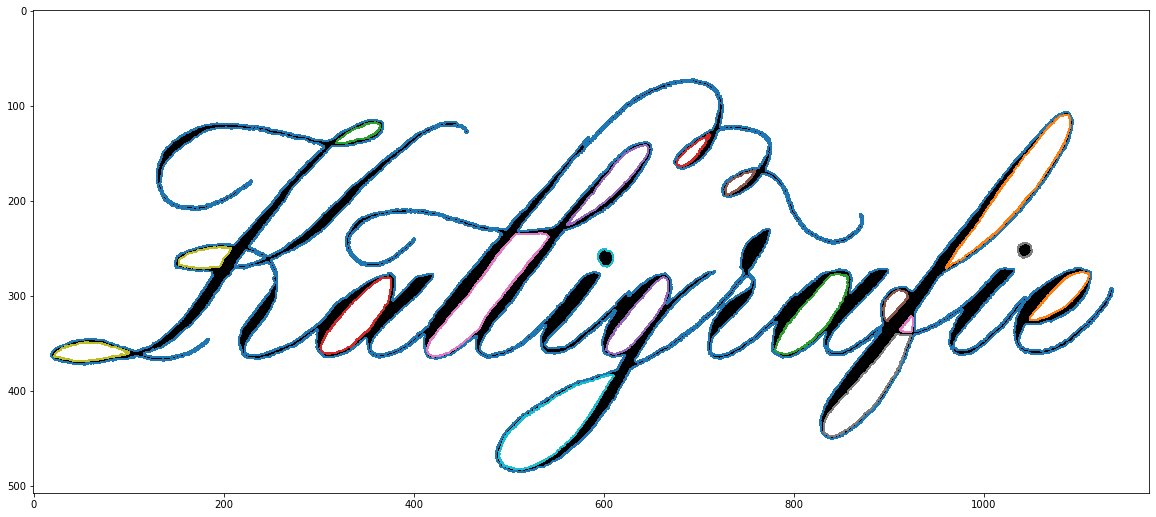

In [894]:
from skimage import measure

contours = measure.find_contours(x)

# Display the image and plot all contours found
plt.rcParams['figure.figsize'] = (20, 20)

fig, ax = plt.subplots()
ax.imshow(x, cmap='gray', interpolation='nearest')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, antialiased=False)

plt.show()

In [895]:
for contour in contours:
    print(len(contour))

14117
587
139
137
341
117
521
61
165
69
99
225
331
315
293
117
61
403
215
443


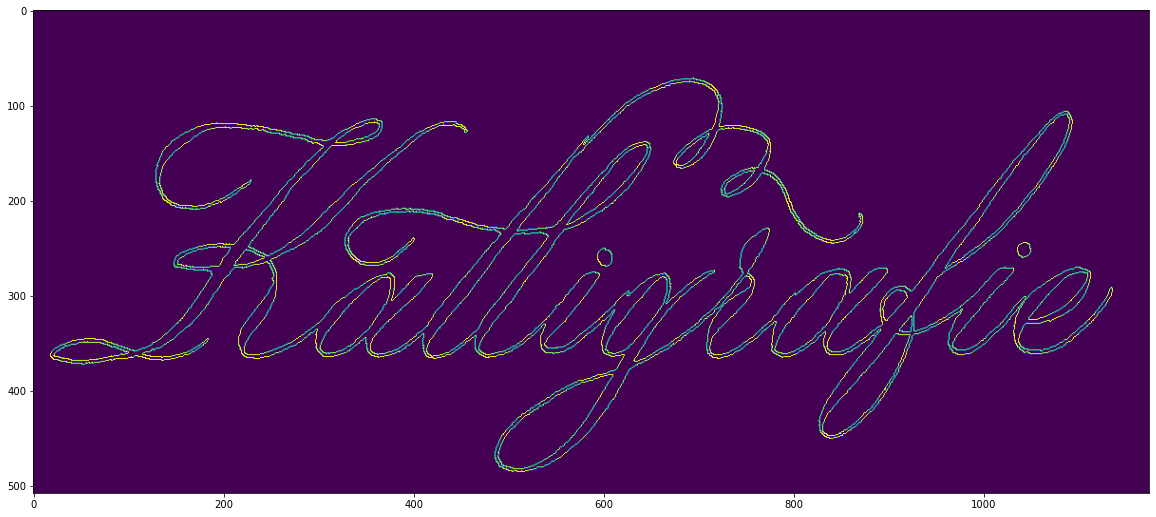

In [896]:
# Convert coordinates to image
contour_img = np.ma.array(np.zeros(np.shape(x)))
for contour in contours:
    for pixel in np.int32(contour):
        contour_img[pixel[0], pixel[1]] = 1

plt.imshow(contour_img)

## Corner detection

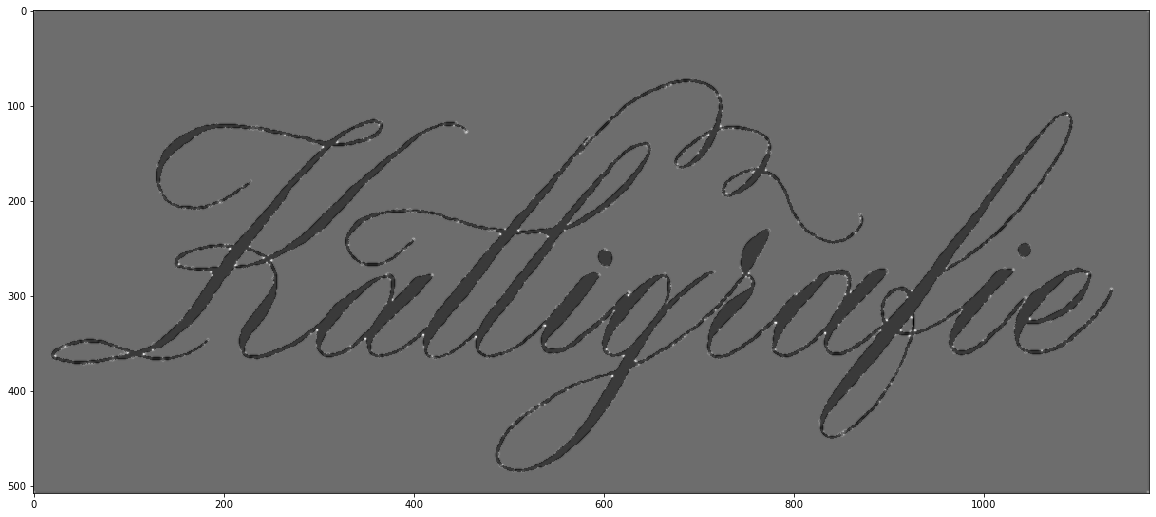

In [897]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

corners = corner_harris(x)

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

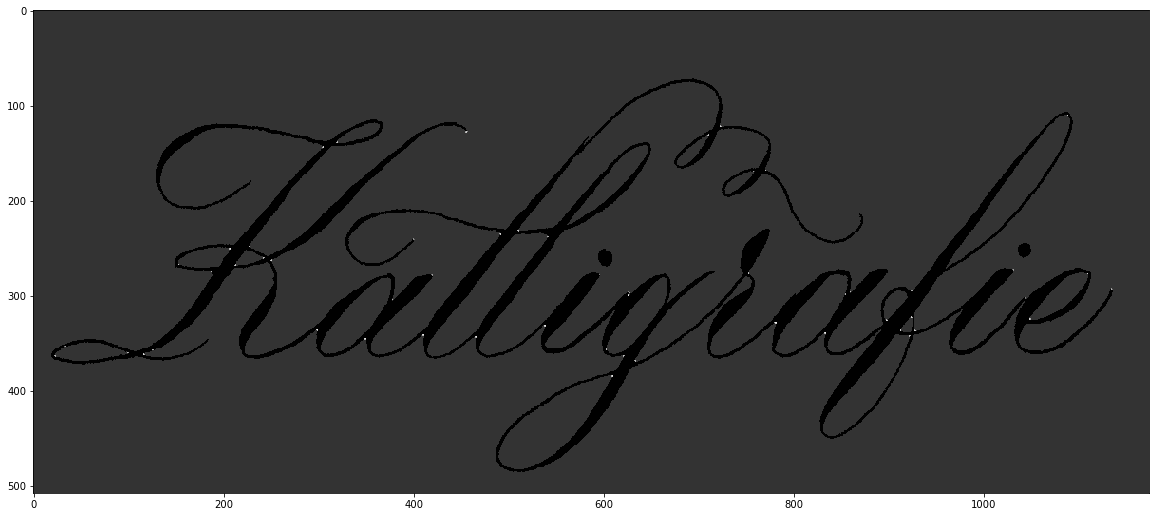

In [898]:
corners[corners < 15] = 0

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

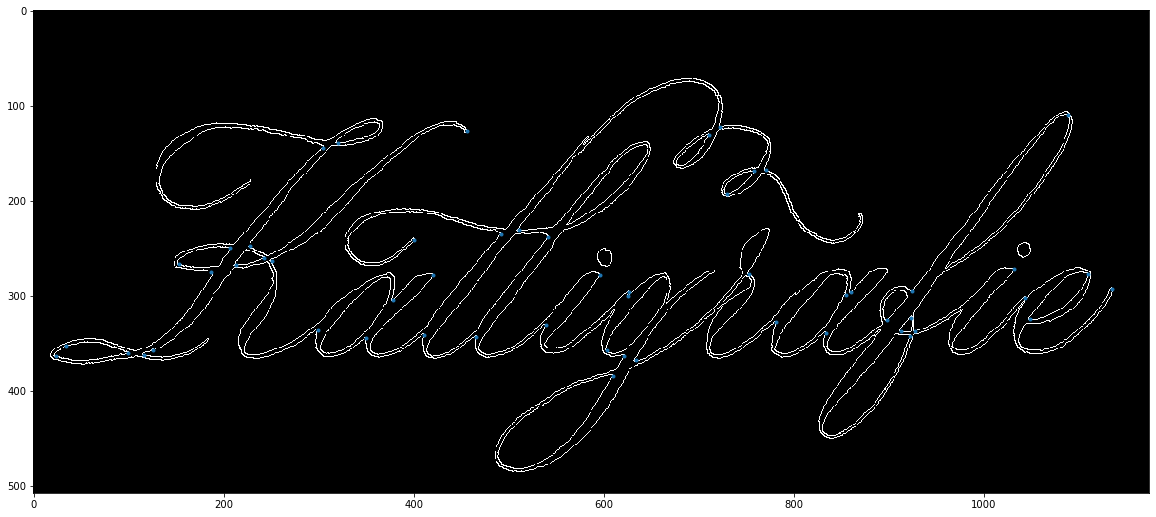

In [899]:
from skimage.feature import peak_local_max

corner_coords = peak_local_max(corners)
# Move coordinates onto contour
for coord in corner_coords:
    distances = np.sqrt((contour_img[0] - coord[0]) ** 2 + (contour_img[1] - coord[1]) ** 2)
    coord = np.argmin(distances)

fig, ax = plt.subplots()
ax.imshow(contour_img, cmap=plt.cm.gray, interpolation='nearest')
ax.plot(corner_coords[:, 1], corner_coords[:, 0], antialiased=False, marker='.', linestyle='none')
plt.show()

## Split by corners

In [942]:
def split_contour_by_corners(contour, corners):
    segments = []
    last_segmentation_index = 0
    for i, pixel in enumerate(np.int32(contour)):
        for j, corner in enumerate(corners):
            #print(corner[0], pixel[0], corner[1], pixel[1])
            if corner[0] == pixel[0] and corner[1] == pixel[1]:
                new_row = contour[last_segmentation_index:(i + 1)]
                segments.append(new_row)
                last_segmentation_index = i

    new_row = contour[last_segmentation_index:(len(contour) + 1)]
    segments.append(new_row)
    return segments


contours_in_segments = []
for contour in contours:
    contours_in_segments.append(split_contour_by_corners(contour, corner_coords))


#contours_in_segments[0][0]

#for contour in contours_in_segments:
#    for segment in contour:
#        print(segment)
#        points = np.array([segment[:,0], np.flipud(segment[:,1])])
#        print(points)

## Curve fitting
https://github.com/volkerp/fitCurves

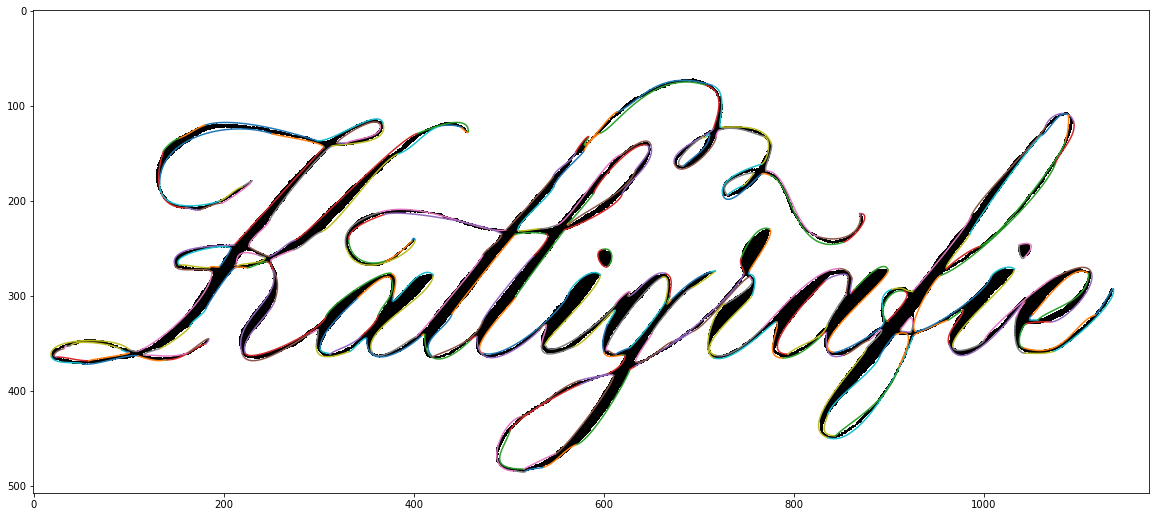

In [950]:
from bezier import *
from fitCurves import *

maxError = 10

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')

for contour in contours_in_segments:
    for segment in contour:
        #points = np.array([segment[:,0], segment[:,1]])
        points = segment
        #print(points)

        beziers = fitCurve(points, maxError)
        #print(beziers)

        for bez in beziers:
            bez = np.stack(bez)
            curve = []
            for t in np.linspace(0,1,50):
                curve.append(bezier.q(bez, t))

            curve = np.stack(curve)
            ax.plot(curve[:,1], curve[:,0])

        #ax.plot(points[:,1], points[:,0], antialiased=False)


plt.show()